In [30]:
%%capture
from jupyter_tikz import TexFragment
import os, sys
from IPython.display import display, HTML, Markdown, Math

# To find local version of the library
sys.path.append('../src')

from pmule import PredecessorTable, ProjectGraph
%mkdir -p ~/temp
%cd ~/temp

## Enunciado

Considere la información del proyecto cuya información aparece en la tabla adjunta:    

In [31]:
pregunta_1 = "1. ¿Cuál es la probabilidad de terminar el proyecto entre 12 y 14 periodos?  "
pregunta_2 = "2. Respecto a la situación original del enunciado, indique mediante el método de Ackoff-Sasieni cuales serían las actuaciones a llevar a cabo para reducir con mínimo sobrecoste la duración media del proyecto a 10 periodos.  "
pregunta_3 = "3. Respecto a la situación original del enunciado, indique cuales serían las actuaciones para poder ejecutar el proyecto con un límite en los recursos de 8 recursos por periodo durante los primeros siete periodos.  "
pregunta_4 = "4. Respecto a la situación original del enunciado, calcule el valor del CPI y del SPI para el punto de control cuyos datos se proporcionan.  "

In [32]:
display(Markdown(pregunta_1))
display(Markdown(pregunta_2))
display(Markdown(pregunta_3))
display(Markdown(pregunta_4))

1. ¿Cuál es la probabilidad de terminar el proyecto entre 12 y 14 periodos?  

2. Respecto a la situación original del enunciado, indique mediante el método de Ackoff-Sasieni cuales serían las actuaciones a llevar a cabo para reducir con mínimo sobrecoste la duración media del proyecto a 10 periodos.  

3. Respecto a la situación original del enunciado, indique cuales serían las actuaciones para poder ejecutar el proyecto con un límite en los recursos de 8 recursos por periodo durante los primeros siete periodos.  

4. Respecto a la situación original del enunciado, calcule el valor del CPI y del SPI para el punto de control cuyos datos se proporcionan.  

In [33]:
import pandas as pd
import numpy as np
pd.set_option('future.no_silent_downcasting', True)

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, duracion, duracion_tope, desviación, coste_planificado, coste_real, duracion_real, realizado, cur, recursos
     ('A',      'D      ',       2,         1,              0.2,         80,              80,          2,           100,   80,    4 ),
     ('B',      'A      ',       2,         1,              0.3,         70,              60,          2,            80,   10,    2 ),
     ('C',      'B      ',       3,         1,              0.4,         60,               0,          0,             0,   40,    1 ),
     ('D',      '---    ',       4,         3,              0.5,         40,              50,          5,           100,   20,    4 ),
     ('E',      'A      ',       1,         1,              0.1,         40,              30,          3,           100,   30,    3 ),
     ('F',      'D,E    ',       2,         1,              0.3,         10,              10,          3,            80,   40,    5 ),
     ('G',      '---    ',       4,         1,              0.1,         40,              50,          3,           100,   20,    4 ),
     ('H',      'I    ',       4,         2,              0.5,        100,             140,          4,            90,   50,    2 ),
     ('I',      'D      ',       2,         1,              0.1,         50,              70,          1,            50,   60,    3 ),
     ('J',      'F,H,K  ',       2,         1,              0.4,         50,               0,          0,             0,   70,    1 ),
     ('K',      'D,G    ',       4,         1,              0.2,         40,              30,          2,            60,   90,    2 ),
     ('L',      'H,K    ',       1,         1,              0.2,         30,               0,          0,             0,   10,    3 ),
] ,columns=['activity', 'predecessor', 'duration', 'cap_duration', 'standard_deviation', 'planned_value', 'actual_cost',
            'actual_duration', 'performed', 'ucr', 'resources']).set_index('activity')
tabla = datos_enunciado.copy()
tabla.columns = ["Pred.", 'Duration', 'Cap <br> duration', 'Standard <br> deviation', 'PV', 'AC',
            'Actual <br> duration', 'Performed', 'UCR', 'Resources']
display(tabla.style.set_properties(**{'text-align': 'center'}).format(precision=2))

,Pred.,Duration,Cap duration,Standard deviation,PV,AC,Actual duration,Performed,UCR,Resources
activity,,,,,,,,,,
A,D,2,1,0.20,80,80,2,100,80,4
B,A,2,1,0.30,70,60,2,80,10,2
C,B,3,1,0.40,60,0,0,0,40,1
D,---,4,3,0.50,40,50,5,100,20,4
E,A,1,1,0.10,40,30,3,100,30,3
F,"D,E",2,1,0.30,10,10,3,80,40,5
G,---,4,1,0.10,40,50,3,100,20,4
H,I,4,2,0.50,100,140,4,90,50,2
I,D,2,1,0.10,50,70,1,50,60,3


{{< pagebreak >}}

## Solución
### Apartado 1


In [34]:
display(Markdown(pregunta_1))

1. ¿Cuál es la probabilidad de terminar el proyecto entre 12 y 14 periodos?  

#### Duración media del proyecto

In [35]:
from pmule import ProjectGraph, PredecessorTable

In [36]:
datos_proyecto=datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessor')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J,K,L
activities,,,,,,,,,,,,
A,,,,True,,,,,,,,
B,True,,,,,,,,,,,
C,,True,,,,,,,,,,
D,,,,,,,,,,,,
E,True,,,,,,,,,,,
F,,,,,True,,,,,,,
G,,,,,,,,,,,,
H,,,,,,,,,True,,,
I,,,,True,,,,,,,,


##### Grafo PERT con numeración de nodos

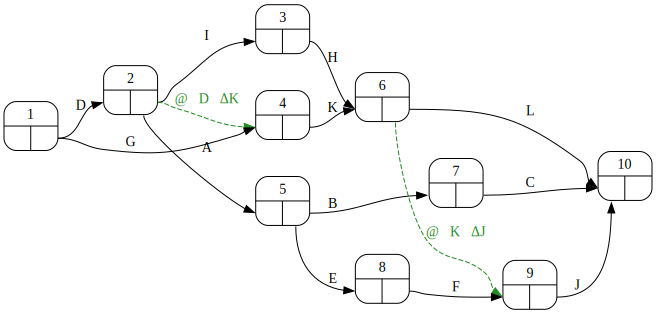

In [37]:
proyecto = prelaciones.create_project()
proyecto.pert()

{{< pagebreak >}}

##### Matriz de Zaderenko

In [38]:
proyecto.zaderenko(durations=datos_proyecto['duration'])

,1,2,3,4,5,6,7,8,9,10,early
1,,4.0,,4.0,,,,,,,0.0
2,,,2.0,0.0,2.0,,,,,,4.0
3,,,,,,4.0,,,,,6.0
4,,,,,,4.0,,,,,4.0
5,,,,,,,2.0,1.0,,,6.0
6,,,,,,,,,0.0,1.0,10.0
7,,,,,,,,,,3.0,8.0
8,,,,,,,,,2.0,,7.0
9,,,,,,,,,,2.0,10.0
10,,,,,,,,,,,12.0


In [39]:
resultados_pert = proyecto.calculate_pert(durations=datos_proyecto['duration'])
resultados_pert['nodes'].T

,1,2,3,4,5,6,7,8,9,10
early,0,4,6,4,6,10,8,7,10,12
late,0,4,6,6,7,10,9,8,10,12


##### Duración media del proyecto

In [40]:
duracion_media_proyecto = int(proyecto.duration(durations=datos_proyecto['duration']))

In [41]:
Markdown(f"La duración media del proyecto es {duracion_media_proyecto}")

La duración media del proyecto es 12

{{< pagebreak >}}

#### Varianza de la duración del proyecto
Para determinar la varianza de la duración del proyecto es necesario determinar la varianza de cada rama del camino crítico.

##### Holguras

In [42]:
resultados_pert['activities'][['H_total']].T

,@∇D⤑ΔK,@∇K⤑ΔJ,A,B,C,D,E,F,G,H,I,J,K,L
H_total,2,0,1,1,1,0,1,1,2,0,0,0,2,1


##### Camino crítico
El camino crítico es:

In [43]:
proyecto.display_critical_path(durations=datos_proyecto['duration'])

Route_3:	D, H, I, J <br> 

##### Grafo PERT con indicación del camino crítico

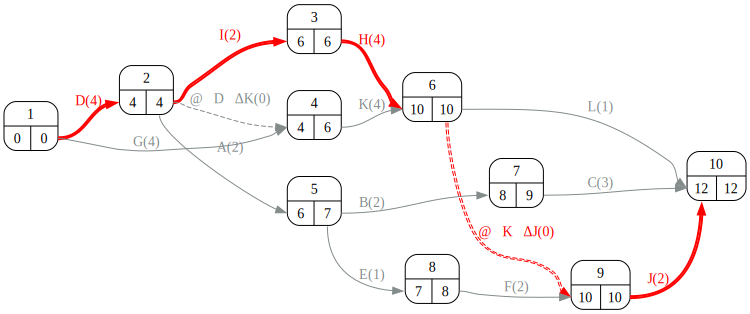

In [44]:
proyecto.pert(durations=datos_proyecto['duration'])

##### Varianza de cada rama

La desviación típica pueda calcularse para cada ruta del camino crítico. En este caso sólo existe una ruta

In [45]:
datos_proyecto['variance'] = datos_proyecto.eval('standard_deviation ** 2')
desviacion_proyecto = round(float(proyecto.standard_deviation(durations=datos_proyecto['duration'],
                                                   variances=datos_proyecto['variance']) )
                            , 2)
Markdown(f"Por tanto, la desviación típica del proyecto resulta ser $\\sigma$ = {desviacion_proyecto}")

Variance path: Route_3 : 0.67
Project duration variance: 0.67
Project duration standard deviation: 0.8185352771872451


Por tanto, la desviación típica del proyecto resulta ser $\sigma$ = 0.82

#### Probabilidad de terminar en el intervalo especificado

In [46]:
import scipy
from scipy.stats import norm

a=12
b=14

probabilidad_de_terminar_antes_de_b = norm.cdf(b, loc=duracion_media_proyecto, scale=desviacion_proyecto)
probabilidad_de_terminar_antes_de_a = norm.cdf(a, loc=duracion_media_proyecto, scale=desviacion_proyecto)

probabilidad_de_terminar_entre_a_y_b = probabilidad_de_terminar_antes_de_b - probabilidad_de_terminar_antes_de_a
probabilidad_de_terminar_entre_a_y_b = round(float(probabilidad_de_terminar_entre_a_y_b * 100), 2)

In [47]:
Markdown(f"""
La probabilidad de terminar entre {a} y {b} periodos viene determinada por la distribución normal de media {duracion_media_proyecto} y desviación típica {desviacion_proyecto} .
En este caso resulta es {probabilidad_de_terminar_entre_a_y_b} por ciento.""")


La probabilidad de terminar entre 12 y 14 periodos viene determinada por la distribución normal de media 12 y desviación típica 0.82 .
En este caso resulta es 49.26 por ciento.

### Apartado 2

In [48]:
display(Markdown(pregunta_2))

2. Respecto a la situación original del enunciado, indique mediante el método de Ackoff-Sasieni cuales serían las actuaciones a llevar a cabo para reducir con mínimo sobrecoste la duración media del proyecto a 10 periodos.  

In [49]:
datos_proyecto = datos_enunciado.copy()
proyecto = prelaciones.create_project()

In [50]:
ackoff, best_option, duration, available = proyecto.ackoff(durations     = datos_proyecto['duration'],
                                                           min_durations = datos_proyecto['cap_duration'],
                                                           costs         = datos_proyecto['ucr'],
                                                           reduction     = 2
                                                          )
ackoff

Step: 0,	 Critical paths: ['Route_3']
		 Best option: ['D'], 	 Cost: 20
Step: 1,	 Critical paths: ['Route_3']
		 Best option: ['H'], 	 Cost: 50

--------------------------------------------------------------------------------


,A,B,C,D,E,F,G,H,I,J,K,L,0,1,2
Route_1,80.0,10.0,40.0,20.0,,,,,,,,,11.0,10.0,10.0
Route_2,80.0,,,20.0,30.0,40.0,,,,70.0,,,11.0,10.0,10.0
Route_3,,,,20.0,,,,50.0,60.0,70.0,,,12.0,11.0,10.0
Route_4,,,,20.0,,,,50.0,60.0,,,10.0,11.0,10.0,9.0
Route_5,,,,20.0,,,,,,70.0,90.0,,10.0,9.0,9.0
Route_6,,,,20.0,,,,,,,90.0,10.0,9.0,8.0,8.0
Route_7,,,,,,,20.0,,,70.0,90.0,,10.0,10.0,10.0
Route_8,,,,,,,20.0,,,,90.0,10.0,9.0,9.0,9.0
0,1.0,1.0,2.0,1.0,0.0,1.0,3.0,2.0,1.0,1.0,3.0,0.0,,,
1,1.0,1.0,2.0,0.0,0.0,1.0,3.0,2.0,1.0,1.0,3.0,0.0,,,


### Apartado 3

In [51]:
display(Markdown(pregunta_3))

3. Respecto a la situación original del enunciado, indique cuales serían las actuaciones para poder ejecutar el proyecto con un límite en los recursos de 8 recursos por periodo durante los primeros siete periodos.  

Para responder este apartado es necesario representar la demanda de recursos a lo largo del tiempo.

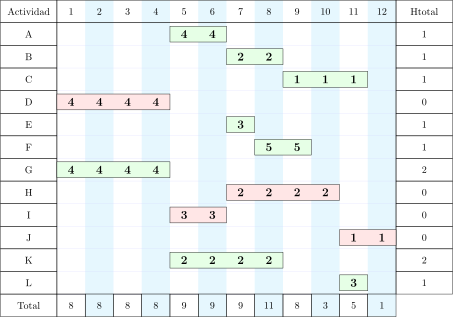

In [52]:
proyecto_asignacion = proyecto.copy()
gantt, dibujo = proyecto_asignacion.gantt(datos_proyecto,
                          'duration',
                          'resources',
                          total='fila',
                          holguras=True, 
                          tikz=True)
TexFragment(dibujo).run_latex()

La demanda de recursos actual infringe el límite impuesto. Es necesario aplicar el algoritmo de asignación.

{{< pagebreak >}}

#### Algoritmo de asignación

 El primer periodo problemático es el 5.

##### Asignación periodo 5

Las actividades inicialmente programadas para el periodo 5 son A, I, K. 
La la actividad I se ejecutará por ser crítica. Deja 4 recursos para A o K. De las dos, es A la más prioritaria por tener menos holgura. Se ejecuta A y retrasa K. La planificación queda de la siguiente forma:

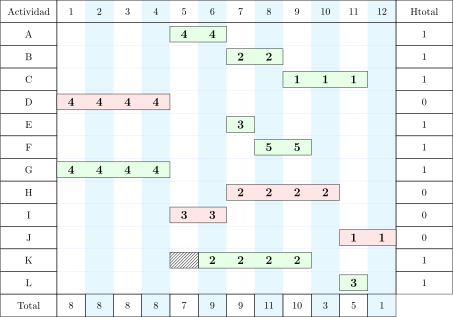

In [53]:
duration_resources = datos_proyecto[['duration','resources']].copy()
duration_resources, df, dibujo = proyecto_asignacion.desplazar(data=duration_resources,
                                                               duration_label='duration',
                                                               resource_label='resources',
                                                               holguras = True,
                                                               cuadrados=False,
                                                               K = 1,
                                                               tikz=True)
TexFragment(dibujo, tikz_libraries='patterns').run_latex()

{{< pagebreak >}}

##### Asignación periodo 6

Las actividades I, A ya se están ejecutando y no se interrumpen. Se desplaza otra vez K. La planificación queda de la siguiente forma:

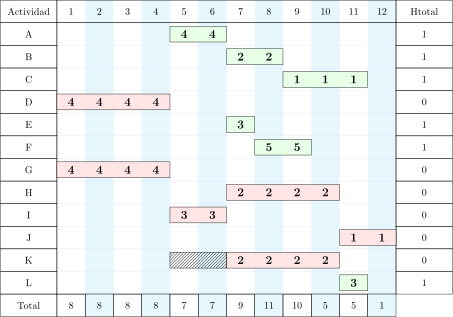

In [54]:
duration_resources, df, dibujo = proyecto_asignacion.desplazar(data=duration_resources,
                                                               duration_label='duration', 
                                                               resource_label='resources',
                                                               holguras=True,
                                                               cuadrados=False,
                                                               tikz=True, K = 1)
TexFragment(dibujo, tikz_libraries='patterns').run_latex()

{{< pagebreak >}}

##### Asignación periodo 7

Las actividades H y K son críticas y se ejecutan. E y B tienen la misma holgura. Se aplica entonces el criterio de ejecutar la más corta, y se retrasa B.

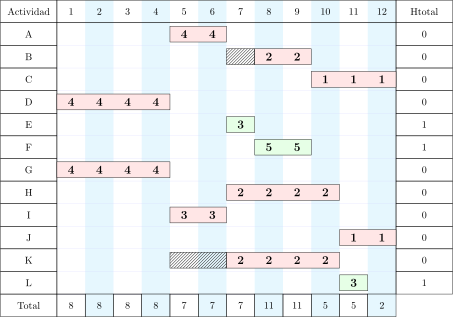

In [55]:
duration_resources, df, dibujo = proyecto_asignacion.desplazar(data=duration_resources, 
                                                               duration_label='duration', 
                                                               resource_label='resources', 
                                                               cuadrados=False, 
                                                               tikz=True,
                                                               B = 1)
TexFragment(dibujo, tikz_libraries='patterns').run_latex()

### Apartado 4

In [56]:
display(Markdown(pregunta_4))

4. Respecto a la situación original del enunciado, calcule el valor del CPI y del SPI para el punto de control cuyos datos se proporcionan.  

In [57]:
PV = int(datos_proyecto['planned_value'].sum())
EV = int(datos_proyecto.eval('planned_value * performed / 100').sum())
AC = int(datos_proyecto['actual_cost'].sum())
CPI = float(EV/AC)
SPI=float(EV/PV)

In [58]:
Markdown(f"""Utilizando CPI=EV/AC y SPI=EV/PV, tenemos:  
PV={PV}  
EV={EV}  
AC={AC}  
CPI={round(CPI,2)}  
SPI={round(SPI,2)}""")

Utilizando CPI=EV/AC y SPI=EV/PV, tenemos:  
PV=610  
EV=403  
AC=520  
CPI=0.78  
SPI=0.66